In [1]:
import pandas as pd
import pickle as pkl
import ast

# Classification Eval Metrics

In [364]:
from collections import Counter
def generate_fact_score(verdicts):
    label = None
    perc_unverified = 0
    v_cleaned = verdicts
    if 'Unverifiable' in verdicts:
        v_cleaned = verdicts[:]
        v_cleaned.remove('Unverifiable')
        perc_unverified = Counter(verdicts)['Unverifiable'] / len(verdicts)
    perc_true = Counter(verdicts)['True'] / len(verdicts)
    perc_false = Counter(verdicts)['False'] / len(verdicts)
    perc = [perc_true, perc_false, perc_unverified]
    winner = np.argwhere(perc == np.amax(perc))

    if len(winner) == 3: # three-way tie
        label = "Unverifiable"

    elif len(winner) == 2: # two-way tie
        if 0 in winner and 1 in winner: # half true
            label = 'Half True'
        elif 0 in winner and 2 in winner: # true & unverifable
            label = "Unverifiable"
        elif 1 in winner and 2 in winner: # false & unverifable
            label = "Unverifiable"

    elif len(winner) == 1:
        if 0 in winner:
            if perc_true == 1: # all true
                label = "True"
            elif Counter(v_cleaned)['True'] / len(v_cleaned) > 0.5: # mostly true
                label = "Mostly True"
            else:
                label = 'Unverifiable'
        elif 1 in winner:
            if perc_false == 1: # all false
                label = "Pants on Fire"
            elif Counter(v_cleaned)['False'] / len(v_cleaned) > 0.5: # mostly false
                label = "Mostly False"
            else:
                label = 'Unverifiable'
        elif 2 in winner:
            label = 'Unverifiable'
    return label

In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def generate_cost_matrix(num_classes):
    """
    Generate a cost matrix for ordinal classification problems. 
    The cost matrix is based on the absolute difference between the true and predicted class labels.
    The cost of misclassifying a sample from class i as class j is defined as the absolute difference between i and j. 
    For example, misclassifying class 1 as class 2 has a cost of 1, while misclassifying class 1 as class 6 has a cost of 5. 
    
    Args:
        num_classes (int): The number of classes.
        
    Returns:
        np.ndarray: The cost matrix of shape (num_classes, num_classes).
    """
    cost_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for i in range(num_classes):
        for j in range(num_classes):
            cost_matrix[i, j] = abs(i - j)
    
    return cost_matrix

# Define the class labels (higher score in increasing order of truthfulness)
class_labels = ["unverifiable", "false", "mostly false", "half true", "mostly true", "true"]
class_2_index = {label: i for i, label in enumerate(class_labels)}
index_2_class = {i: label for i, label in enumerate(class_labels)}
num_labels = [class_2_index[label] for label in class_labels] # [0, 1, 2, 3, 4, 5]
class_labels = {"unverifiable": 0,
                "pants on fire": 1,  
                "false": 1, 
                "mostly false": 2, 
                "half true": 3, 
                "mostly true": 4, 
                "true": 5}

# Example scoring done
fact_score_labels_pred = ['True', 'Mostly True', 'Half True', 'Mostly False', 'Pants On Fire', 'Unverifiable', 'True', 'Mostly True', 'Half True', 'Mostly False']
fact_score_labels_true = ['Mostly True', 'Mostly True', 'Half True', 'Mostly False', 'Pants On Fire', 'Unverifiable', 'True', 'Mostly True', 'Half True', 'Mostly False']

# Assume you have the true labels and predicted labels
y_pred = [class_labels[f.lower()] for f in fact_score_labels_pred]
y_true = [class_labels[f.lower()] for f in fact_score_labels_true]

# Generate the cost matrix for 6 classes
cost_matrix = generate_cost_matrix(6)

# Calculate the confusion matrix with the cost matrix
cm = confusion_matrix(y_true, y_pred, sample_weight=None, labels=num_labels)
weighted_cm = cm * cost_matrix

# Calculate the weighted F1 score
weighted_precision = precision_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
weighted_recall = recall_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
weighted_f1 = f1_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)

print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1 Score: {weighted_f1:.2f}")

Weighted Precision: 0.95
Weighted Recall: 0.90
Weighted F1 Score: 0.91


In [3]:
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
import matplotlib.pyplot as plt

In [423]:
import os
path="/Users/sunnyfang/Library/CloudStorage/GoogleDrive-yf2610@barnard.edu/My Drive/courses/AY 23-24/24 SP/COMS-W3997 LLM Foundations & Ethics/LLM Project/LLM-FactChecker"
os.chdir(path)
pilot = pd.read_csv('data/cleaned_pilot.csv')
gpt_complete_df = pd.read_csv('eval_data/gpt_complete.csv')
# gpt_baseline_df = pd.read_csv('eval_data/gpt_baseline.csv')
gpt_baseline_df = pd.read_csv('eval_data/gpt_baseline_v2.csv')
gpt_reasoning_df = pd.read_csv('eval_data/gpt_reasonings.csv')
claude_all_df = pd.read_csv('eval_data/claude_complete.csv')
claude_baseline_df = pd.read_csv('eval_data/claude_baseline.csv')
claude_reasoning_df = pd.read_csv('eval_data/claude_reasonings.csv')
mixtral_df = pd.read_csv('pkl_for_final_dataset/final-mixtral-samples.csv')
mixtral_base_list = pd.read_pickle('pkl_for_final_dataset/fact_check_samples_mixtral_baseline_v0.pkl')
pilot_verdict = pilot['verdict']

# clean up dataset
mixtral_df['verdicts_lst'] = mixtral_df['verdicts'].apply(ast.literal_eval)
mixtral_df['verdict_vote'] = mixtral_df['verdicts_lst'].apply(generate_fact_score)
mixtral_base = [x[0] for x in mixtral_base_list]

gpt_verdict_vote = [class_labels[f.lower()] for f in gpt_complete_df['fact_score']]
gpt_baseline = [class_labels[f.lower()] for f in gpt_baseline_df['verdicts']]
gpt_reasoning = [class_labels[f.lower()] for f in gpt_reasoning_df['verdicts']]
claude_verdict_vote = [class_labels[f.lower()] for f in claude_all_df['fact_score']]
claude_baseline = [class_labels[f.lower()] for f in claude_baseline_df['verdicts']]
claude_reasoning = [class_labels[f.lower()] for f in claude_reasoning_df['verdicts']]
mixtral_verdict_vote = [class_labels[f.lower()] for f in mixtral_df['verdict_vote']]
mixtral_baseline = [class_labels[f.lower()] for f in mixtral_base]
mixtral_reasoning = [class_labels[f.lower()] for f in mixtral_df['fact_score']]
pilot_verdict = [class_labels[f.lower()] for f in pilot_verdict]

In [5]:
def generate_metrics(y_true, y_pred):
    # Generate the cost matrix for 6 classes
    cost_matrix = generate_cost_matrix(6)

    # Calculate the confusion matrix with the cost matrix
    cm = confusion_matrix(y_true, y_pred, sample_weight=None, labels=num_labels)
    weighted_cm = cm * cost_matrix

    # Calculate the weighted F1 score
    weighted_precision = precision_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
    weighted_recall = recall_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)

    print(f"Weighted Precision: {weighted_precision:.2f}")
    print(f"Weighted Recall: {weighted_recall:.2f}")
    print(f"Weighted F1 Score: {weighted_f1:.2f}")

    return cm, weighted_precision, weighted_recall, weighted_f1

## GPT-4-Turbo

In [424]:
gpt_all_cm, gpt_all_precision, gpt_all_recall, gpt_all_f1 = generate_metrics(pilot_verdict, gpt_verdict_vote)
gpt_reasoning_cm, gpt_reasoning_precision, gpt_reasoning_recall, gpt_reasoning_f1 = generate_metrics(pilot_verdict, gpt_reasoning)
gpt_baseline_cm, gpt_baseline_precision, gpt_baseline_recall, gpt_baseline_f1 = generate_metrics(pilot_verdict, gpt_baseline)

Weighted Precision: 0.35
Weighted Recall: 0.20
Weighted F1 Score: 0.23
Weighted Precision: 0.41
Weighted Recall: 0.20
Weighted F1 Score: 0.26
Weighted Precision: 0.64
Weighted Recall: 0.30
Weighted F1 Score: 0.41


## Claude-3-Sonnet

In [390]:
claude_all_cm, claude_all_precision, claude_all_recall, claude_all_f1 = generate_metrics(pilot_verdict, claude_verdict_vote)
claude_reasoning_cm, claude_reasoning_precision, claude_reasoning_recall, claude_reasoning_f1 = generate_metrics(pilot_verdict, claude_reasoning)
claude_baseline_cm, claude_baseline_precision, claude_baseline_recall, claude_baseline_f1 = generate_metrics(pilot_verdict, claude_baseline)

Weighted Precision: 0.57
Weighted Recall: 0.14
Weighted F1 Score: 0.14
Weighted Precision: 0.82
Weighted Recall: 0.38
Weighted F1 Score: 0.45
Weighted Precision: 0.58
Weighted Recall: 0.32
Weighted F1 Score: 0.39


## Mixtral Models

In [388]:
mixtral_all_cm, mixtral_all_precision, mixtral_all_recall, mixtral_all_f1 = generate_metrics(pilot_verdict, mixtral_verdict_vote)
print('*'*20)
mixtral_reasoning_cm, mixtral_reasoning_precision, mixtral_reasoning_recall, mixtral_reasoning_f1 = generate_metrics(pilot_verdict, mixtral_reasoning)
print('*'*20)
mixtral_baseline_cm, mixtral_baseline_precision, mixtral_baseline_recall, mixtral_baseline_f1 = generate_metrics(pilot_verdict, mixtral_baseline)

Weighted Precision: 0.45
Weighted Recall: 0.14
Weighted F1 Score: 0.17
********************
Weighted Precision: 0.55
Weighted Recall: 0.24
Weighted F1 Score: 0.24
********************
Weighted Precision: 0.63
Weighted Recall: 0.30
Weighted F1 Score: 0.32


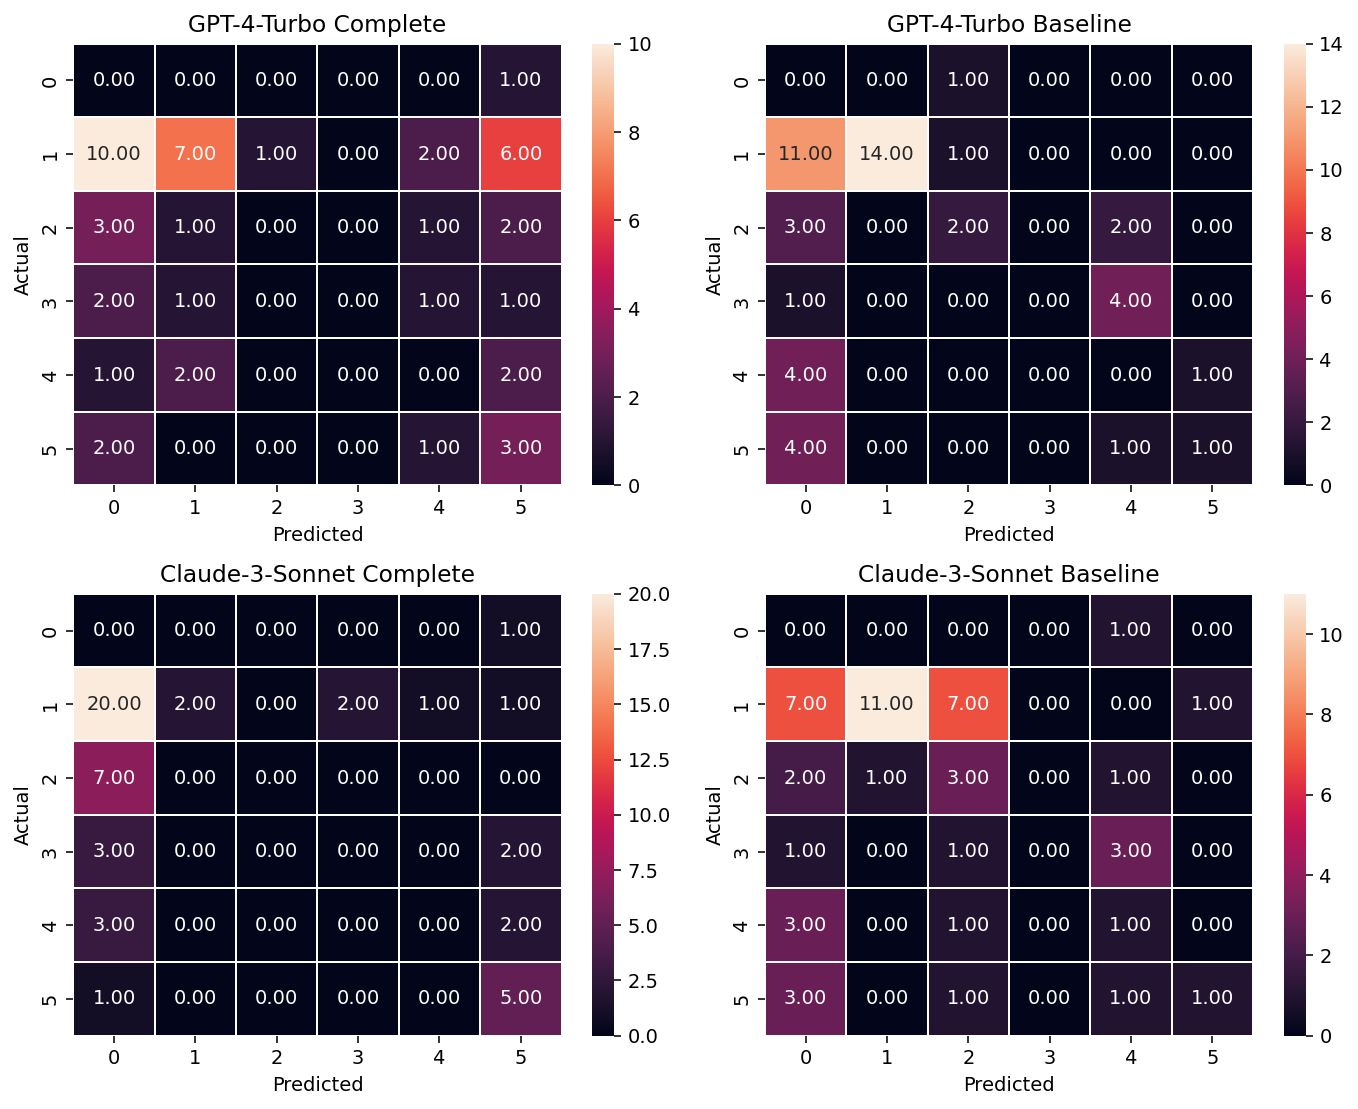

In [78]:
fig, axes = plt.subplots(2, 2, figsize = (10, 8))
plt.rcParams['figure.dpi'] = 300
ax = sns.heatmap(gpt_all_cm, linewidths=1, ax = axes[0,0], annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'GPT-4-Turbo Complete')

ax = sns.heatmap(gpt_baseline_cm, linewidths=1, ax = axes[0,1], annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'GPT-4-Turbo Baseline')

ax = sns.heatmap(claude_all_cm, linewidths=1, ax = axes[1,0], annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Claude-3-Sonnet Complete')

ax = sns.heatmap(claude_baseline_cm, linewidths=1, ax = axes[1,1], annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Claude-3-Sonnet Baseline')

fig.tight_layout(pad=1.0) 


## GROUPED BAR CHART

[<BarContainer object of 9 artists>, <BarContainer object of 9 artists>, <BarContainer object of 9 artists>] ['Precision', 'Recall', 'F1 Score']


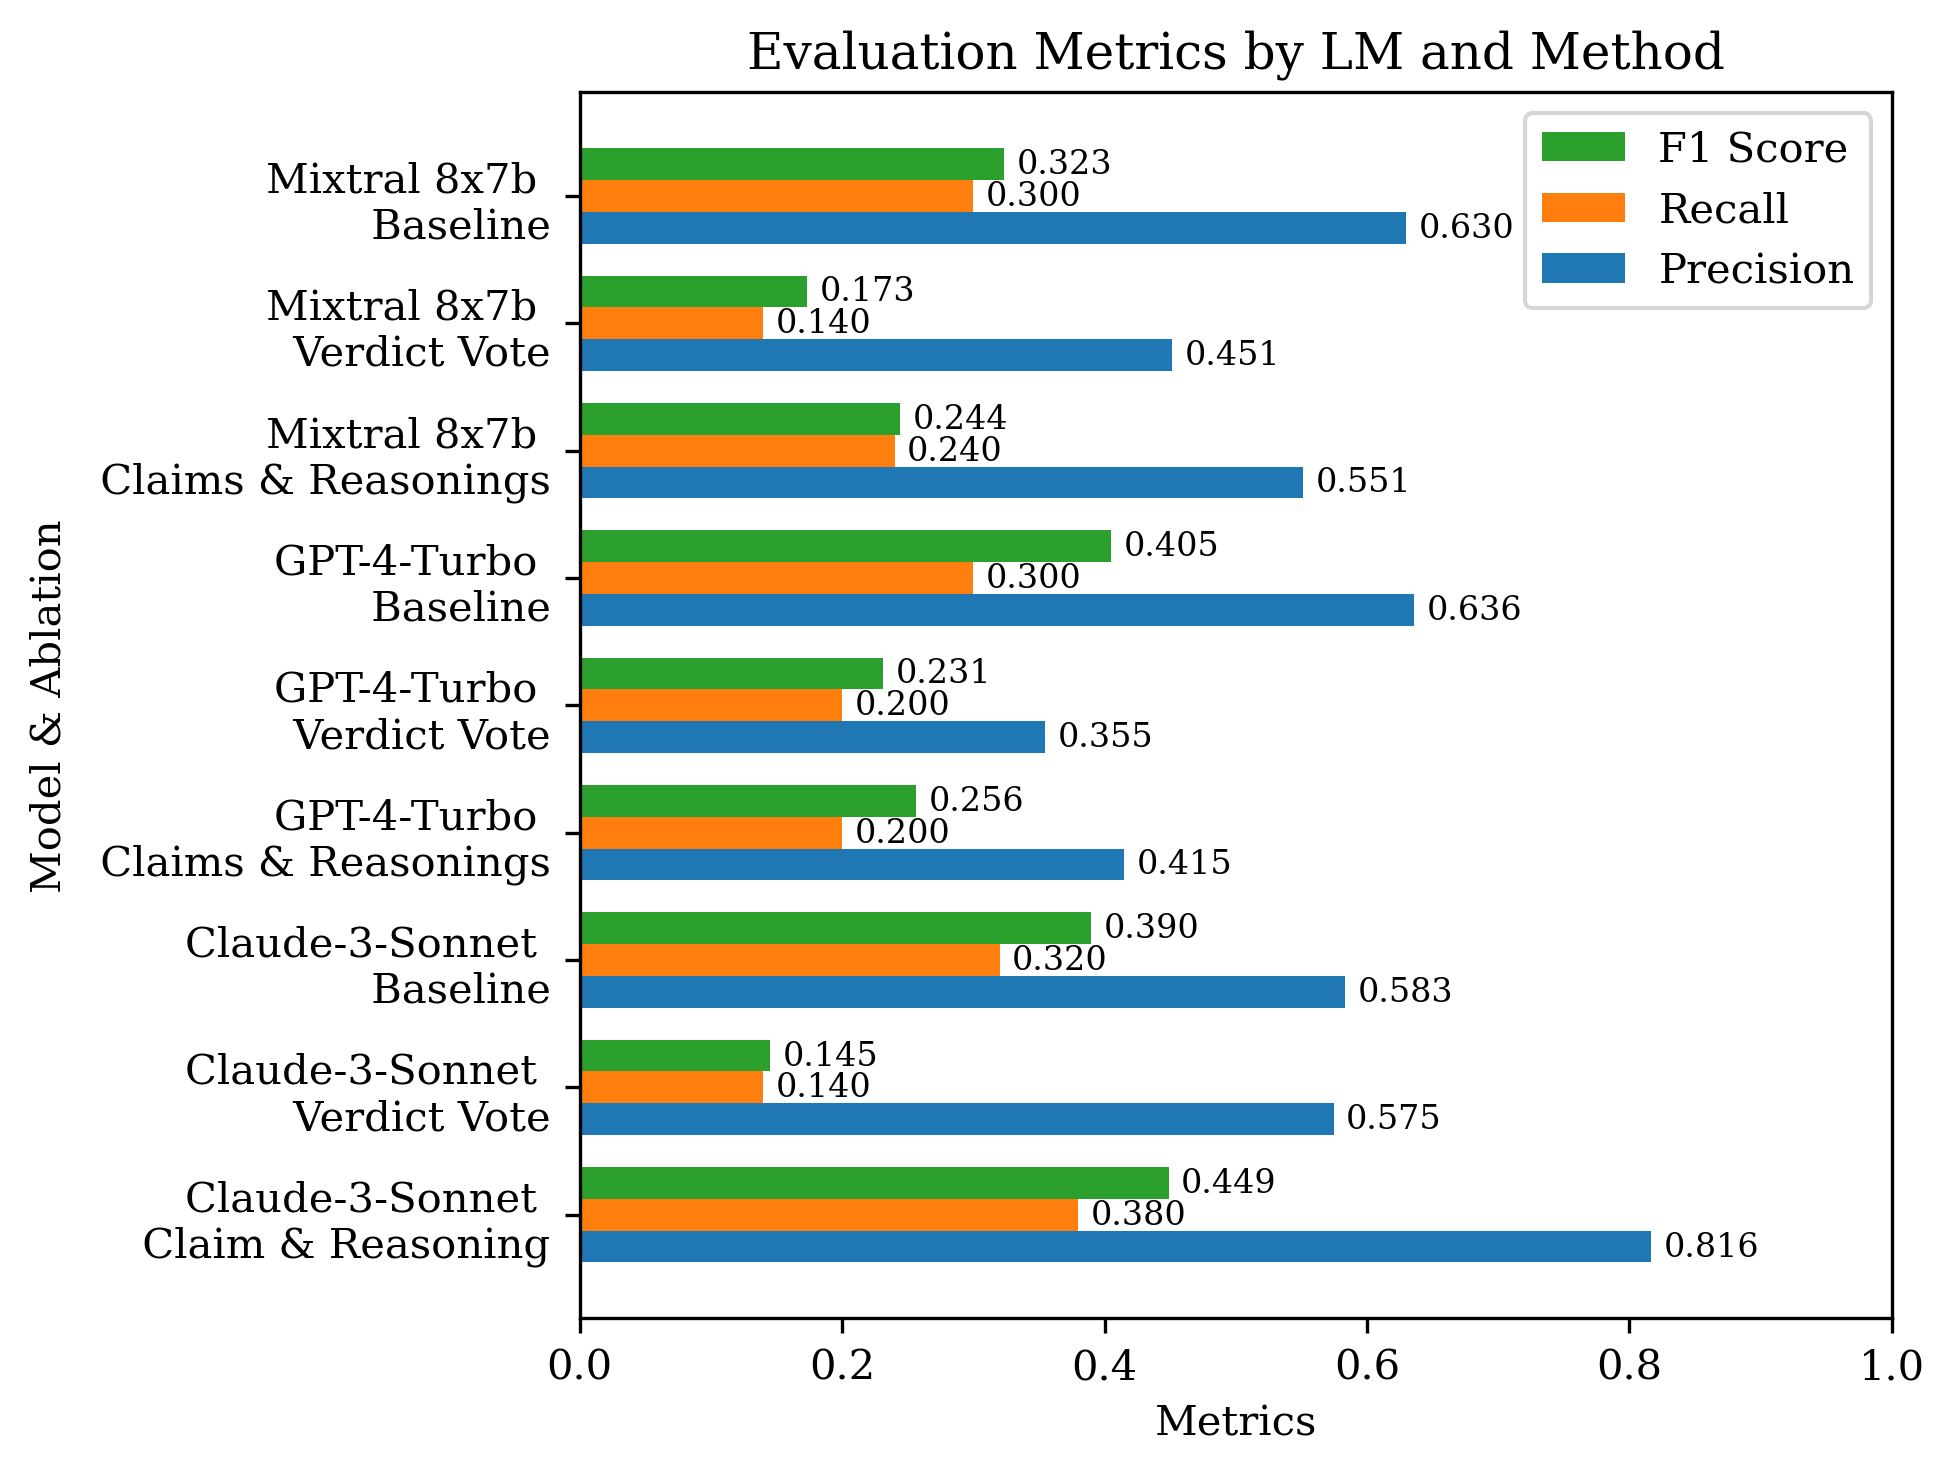

In [425]:
# data from https://allisonhorst.github.io/palmerpenguins/
plt.rcParams["font.family"] = "serif"
labels = ['Claude-3-Sonnet \n Claim & Reasoning', 'Claude-3-Sonnet \n Verdict Vote' , 'Claude-3-Sonnet \n Baseline',
          'GPT-4-Turbo \n Claims & Reasonings', 'GPT-4-Turbo \n Verdict Vote', 'GPT-4-Turbo \n Baseline',
          'Mixtral 8x7b \n Claims & Reasonings', 'Mixtral 8x7b \n Verdict Vote', 'Mixtral 8x7b \n Baseline']
metrics = {
    'Precision': (claude_reasoning_precision, claude_all_precision, claude_baseline_precision, 
                  gpt_reasoning_precision, gpt_all_precision, gpt_baseline_precision,
                  mixtral_reasoning_precision, mixtral_all_precision, mixtral_baseline_precision),
    'Recall': (claude_reasoning_recall, claude_all_recall, claude_baseline_recall, 
               gpt_reasoning_recall, gpt_all_recall, gpt_baseline_recall,
               mixtral_reasoning_recall, mixtral_all_recall, mixtral_baseline_recall),
    'F1 Score': (claude_reasoning_f1, claude_all_f1, claude_baseline_f1, 
                 gpt_reasoning_f1, gpt_all_f1, gpt_baseline_f1,
                 mixtral_reasoning_f1, mixtral_all_f1, mixtral_baseline_f1),
}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in metrics.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.3f', fontsize = 8)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model & Ablation')
ax.set_xlabel('Metrics')
ax.set_title('Evaluation Metrics by LM and Method')
ax.set_yticks(x + width, labels, ha = 'right')
ax.set_xlim(0, 1)
# ax.set_ylim(0, 250)

handles, labels = plt.gca().get_legend_handles_labels()
print(handles, labels)
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

## Delete Unverifiables

In [11]:
def delete_unverifiables(lst, indices):
    new_lst = []
    for i in range(len(lst)):
        if i not in indices:
            new_lst.append(lst[i])
    return new_lst

### GPT-4-Turbo

In [12]:
indices = [i for i, x in enumerate(gpt_verdict_vote) if x == 0]
temp_clean = delete_unverifiables(gpt_verdict_vote, indices)
gold_clean = delete_unverifiables(pilot_verdict, indices)
print(len(temp_clean))
gpt_all_cm_cleaned, gpt_all_precision_cleaned, gpt_all_recall_cleaned, gpt_all_f1_cleaned = generate_metrics(temp_clean, gold_clean)

32
Weighted Precision: 0.50
Weighted Recall: 0.31
Weighted F1 Score: 0.33


In [13]:
indices = [i for i, x in enumerate(gpt_baseline) if x == 0]
temp_clean = delete_unverifiables(gpt_baseline, indices)
gold_clean = delete_unverifiables(pilot_verdict, indices)
print(len(temp_clean))
gpt_base_cm_cleaned, gpt_base_precision_cleaned, gpt_base_recall_cleaned, gpt_base_f1_cleaned = generate_metrics(temp_clean, gold_clean)

27
Weighted Precision: 0.60
Weighted Recall: 0.63
Weighted F1 Score: 0.61


### Claude-3-Sonnet

In [14]:
indices = [i for i, x in enumerate(claude_verdict_vote) if x == 0]
temp_clean = delete_unverifiables(claude_verdict_vote, indices)
gold_clean = delete_unverifiables(pilot_verdict, indices)
print(len(temp_clean))
claude_all_cm_cleaned, claude_all_precision_cleaned, claude_all_recall_cleaned, claude_all_f1_cleaned = generate_metrics(temp_clean, gold_clean)

16
Weighted Precision: 0.73
Weighted Recall: 0.44
Weighted F1 Score: 0.49


In [15]:
indices = [i for i, x in enumerate(claude_baseline) if x == 0]
temp_clean = delete_unverifiables(claude_baseline, indices)
gold_clean = delete_unverifiables(pilot_verdict, indices)
print(len(temp_clean))
claude_baseline_cm_cleaned, claude_baseline_precision_cleaned, claude_baseline_recall_cleaned, claude_baseline_f1_cleaned = generate_metrics(temp_clean, gold_clean)

34
Weighted Precision: 0.56
Weighted Recall: 0.47
Weighted F1 Score: 0.45


In [16]:
from collections import Counter
def generate_fact_score_loose(verdicts):
    verdicts = eval
    label = None
    perc_unverified = 0
    v_cleaned = verdicts
    if 'Unverifiable' in verdicts:
        v_cleaned = verdicts[:]
        v_cleaned.remove('Unverifiable')
        perc_unverified = Counter(verdicts)['Unverifiable'] / len(verdicts)
    perc_true = Counter(verdicts)['True'] / len(verdicts)
    perc_false = Counter(verdicts)['False'] / len(verdicts)
    perc = [perc_true, perc_false, perc_unverified]
    winner = np.argwhere(perc == np.amax(perc))

    if len(winner) == 3: # three-way tie
        label = "Unverifiable"

    elif len(winner) == 2: # two-way tie
        if 0 in winner and 1 in winner: # half true
            label = 'Half True'
        elif 0 in winner and 2 in winner: # true & unverifable
            label = "True"
        elif 1 in winner and 2 in winner: # false & unverifable
            label = "False"

    elif len(winner) == 1:
        if 0 in winner:
            if perc_true == 1: # all true
                label = "True"
            else:
                label = "Mostly True"
        elif 1 in winner:
            if perc_false == 1: # all false
                label = "Pants on Fire"
            else:
                label = "Mostly False"
        elif 2 in winner:
            label = 'Unverifiable'
    return label

In [31]:
import ast
gpt_complete_df['verdicts_lst'] = gpt_complete_df['verdicts'].apply(ast.literal_eval)
gpt_complete_df['fs_loose'] = gpt_complete_df['verdicts_lst'].apply(generate_fact_score_loose)
gpt_fs_loose = [class_labels[f.lower()] for f in gpt_complete_df['fs_loose']]

claude_all_df['verdicts_lst'] = claude_all_df['verdicts'].apply(ast.literal_eval)
claude_all_df['fs_loose'] = claude_all_df['verdicts_lst'].apply(generate_fact_score_loose)
claude_fs_loose = [class_labels[f.lower()] for f in claude_all_df['fs_loose']]

In [32]:
gpt_loose_cm, gpt_loose_precision, gpt_loose_recall, gpt_loose_f1 = generate_metrics(pilot_verdict, gpt_fs_loose)

Weighted Precision: 0.36
Weighted Recall: 0.26
Weighted F1 Score: 0.27


In [46]:
gpt_loose_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, gpt_fs_loose)]
counter = Counter(gpt_loose_factuality_dist)
sorted_dict = dict(sorted(counter.items()))
sorted_dict.values()

dict_values([13, 12, 4, 10, 9, 2])

## Factuality Distance

In [426]:
num_unverifiables = len([i for i in gpt_verdict_vote if i == 0]) 
gpt_complete_temp = [i for i in gpt_verdict_vote if i != 0] 
gpt_complete_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, gpt_complete_temp)]
gpt_complete_fd_counter = dict(sorted(Counter(gpt_complete_factuality_dist).items()))
gpt_complete_fact_dist = list(gpt_complete_fd_counter.values())
gpt_complete_fact_dist.insert(0, num_unverifiables)
if len(gpt_complete_fact_dist) != 7: gpt_complete_fact_dist.append(0)

num_unverifiables = len([i for i in gpt_reasoning if i == 0]) 
gpt_reasoning_temp = [i for i in gpt_reasoning if i != 0] 
gpt_reasoning_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, gpt_reasoning_temp)]
gpt_reasoning_fd_counter = dict(sorted(Counter(gpt_reasoning_factuality_dist).items()))
gpt_reasoning_fact_dist = list(gpt_reasoning_fd_counter.values())
gpt_reasoning_fact_dist.insert(0, num_unverifiables)
if len(gpt_reasoning_fact_dist) != 7: gpt_reasoning_fact_dist.append(0)

num_unverifiables = len([i for i in gpt_baseline if i == 0]) 
gpt_baseline_temp = [i for i in gpt_baseline if i != 0] 
gpt_baseline_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, gpt_baseline_temp)]
gpt_baseline_fd_counter = dict(sorted(Counter(gpt_baseline_factuality_dist).items()))
gpt_baseline_fact_dist = list(gpt_baseline_fd_counter.values())
gpt_baseline_fact_dist.insert(0, num_unverifiables)
if len(gpt_baseline_fact_dist) != 7: gpt_baseline_fact_dist.append(0)

num_unverifiables = len([i for i in claude_verdict_vote if i == 0]) 
claude_all_temp = [i for i in claude_verdict_vote if i != 0] 
claude_complete_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, claude_all_temp)]
claude_complete_fd_counter = dict(sorted(Counter(claude_complete_factuality_dist).items()))
claude_complete_fact_dist = list(claude_complete_fd_counter.values())
claude_complete_fact_dist.insert(0, num_unverifiables)
if len(claude_complete_fact_dist) != 7: claude_complete_fact_dist.append(0)

num_unverifiables = len([i for i in claude_reasoning if i == 0]) 
claude_reasoning_temp = [i for i in claude_reasoning if i != 0] 
claude_reasoning_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, claude_reasoning_temp)]
claude_reasoning_fd_counter = dict(sorted(Counter(claude_reasoning_factuality_dist).items()))
claude_reasoning_fact_dist = list(claude_reasoning_fd_counter.values())
claude_reasoning_fact_dist.insert(0, num_unverifiables)

num_unverifiables = len([i for i in claude_baseline if i == 0]) 
claude_baseline_temp = [i for i in claude_baseline if i != 0] 
claude_baseline_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, claude_baseline_temp)]
claude_baseline_fd_counter = dict(sorted(Counter(claude_baseline_factuality_dist).items()))
claude_baseline_fact_dist = list(claude_baseline_fd_counter.values())
claude_baseline_fact_dist.insert(0, num_unverifiables)
if len(claude_baseline_fact_dist) != 7: claude_baseline_fact_dist.append(0)

num_unverifiables = len([i for i in mixtral_verdict_vote if i == 0]) 
mixtral_all_temp = [i for i in mixtral_verdict_vote if i != 0] 
mixtral_complete_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, mixtral_all_temp)]
mixtral_complete_fd_counter = dict(sorted(Counter(mixtral_complete_factuality_dist).items()))
mixtral_complete_fact_dist = list(mixtral_complete_fd_counter.values())
mixtral_complete_fact_dist.insert(0, num_unverifiables)
if len(mixtral_complete_fact_dist) != 7: mixtral_complete_fact_dist.append(0)

num_unverifiables = len([i for i in mixtral_reasoning if i == 0]) 
mixtral_reasoning_temp = [i for i in mixtral_reasoning if i != 0] 
mixtral_reasoning_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, mixtral_reasoning_temp)]
mixtral_reasoning_fd_counter = dict(sorted(Counter(mixtral_reasoning_factuality_dist).items()))
mixtral_reasoning_fact_dist = list(mixtral_reasoning_fd_counter.values())
mixtral_reasoning_fact_dist.insert(0, num_unverifiables)
if len(mixtral_reasoning_fact_dist) != 7: mixtral_reasoning_fact_dist.append(0)

num_unverifiables = len([i for i in mixtral_baseline if i == 0]) 
mixtral_baseline_temp = [i for i in mixtral_baseline if i != 0] 
mixtral_baseline_factuality_dist = [abs(i - j) for i, j in zip(pilot_verdict, mixtral_baseline_temp)]
mixtral_baseline_fd_counter = dict(sorted(Counter(mixtral_baseline_factuality_dist).items()))
mixtral_baseline_fact_dist = list(mixtral_baseline_fd_counter.values())
mixtral_baseline_fact_dist.insert(0, num_unverifiables)
if len(mixtral_baseline_fact_dist) != 7: mixtral_baseline_fact_dist.append(0)

In [444]:
mixtral_reasoning_fact_dist

[4, 8, 17, 10, 9, 2, 0]

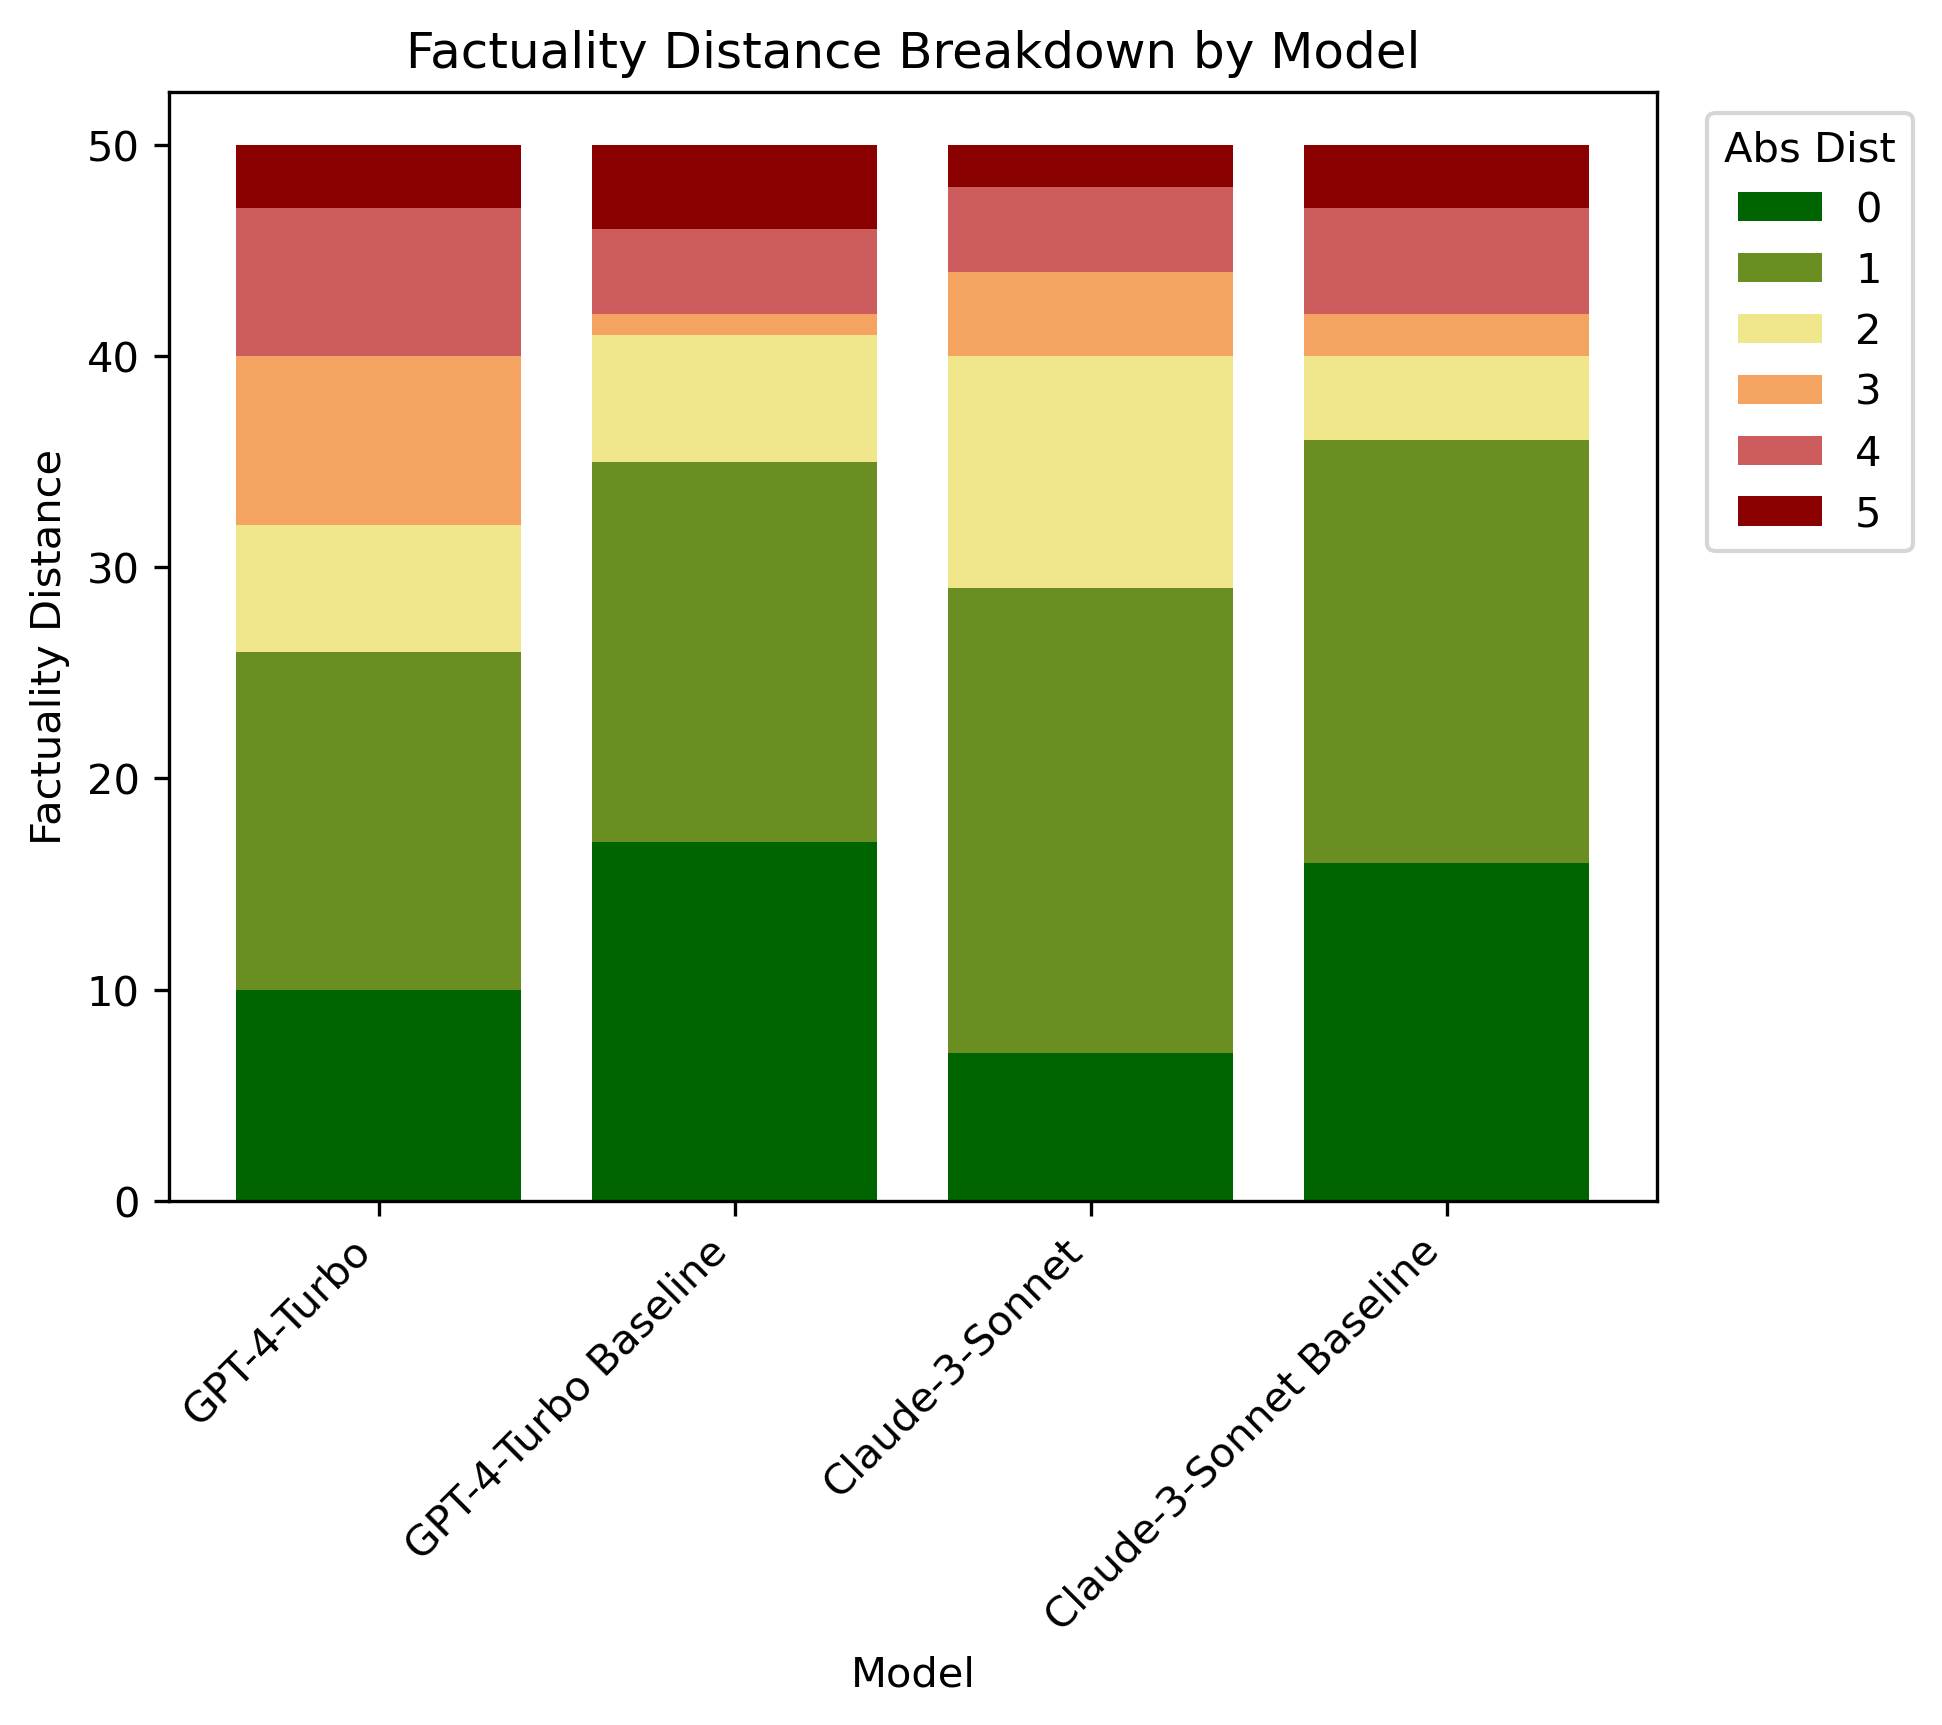

In [91]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
 
# transposed arrays
counts = list(zip(gpt_complete_fact_dist, gpt_baseline_fact_dist, claude_complete_fact_dist, claude_baseline_fact_dist)) 
# create data
x = ['GPT-4-Turbo', 'GPT-4-Turbo Baseline', 'Claude-3-Sonnet', 'Claude-3-Sonnet Baseline']
y1 = np.array(counts[0])
y2 = np.array(counts[1])
y3 = np.array(counts[2])
y4 = np.array(counts[3])
y5 = np.array(counts[4])
y6 = np.array(counts[5])
 
# plot bars in stack manner
plt.bar(x, y1, color='darkgreen')
plt.bar(x, y2, bottom=y1, color='olivedrab')
plt.bar(x, y3, bottom=y1+y2, color='khaki')
plt.bar(x, y4, bottom=y1+y2+y3, color='sandybrown')
plt.bar(x, y5, bottom=y1+y2+y3+y4, color = 'indianred')
plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, color = 'darkred')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Model")
plt.ylabel("Factuality Distance")
plt.title("Factuality Distance Breakdown by Model")
plt.legend(['0','1','2','3','4','5'], bbox_to_anchor=(1.02, 1), title = 'Abs Dist')
plt.show()

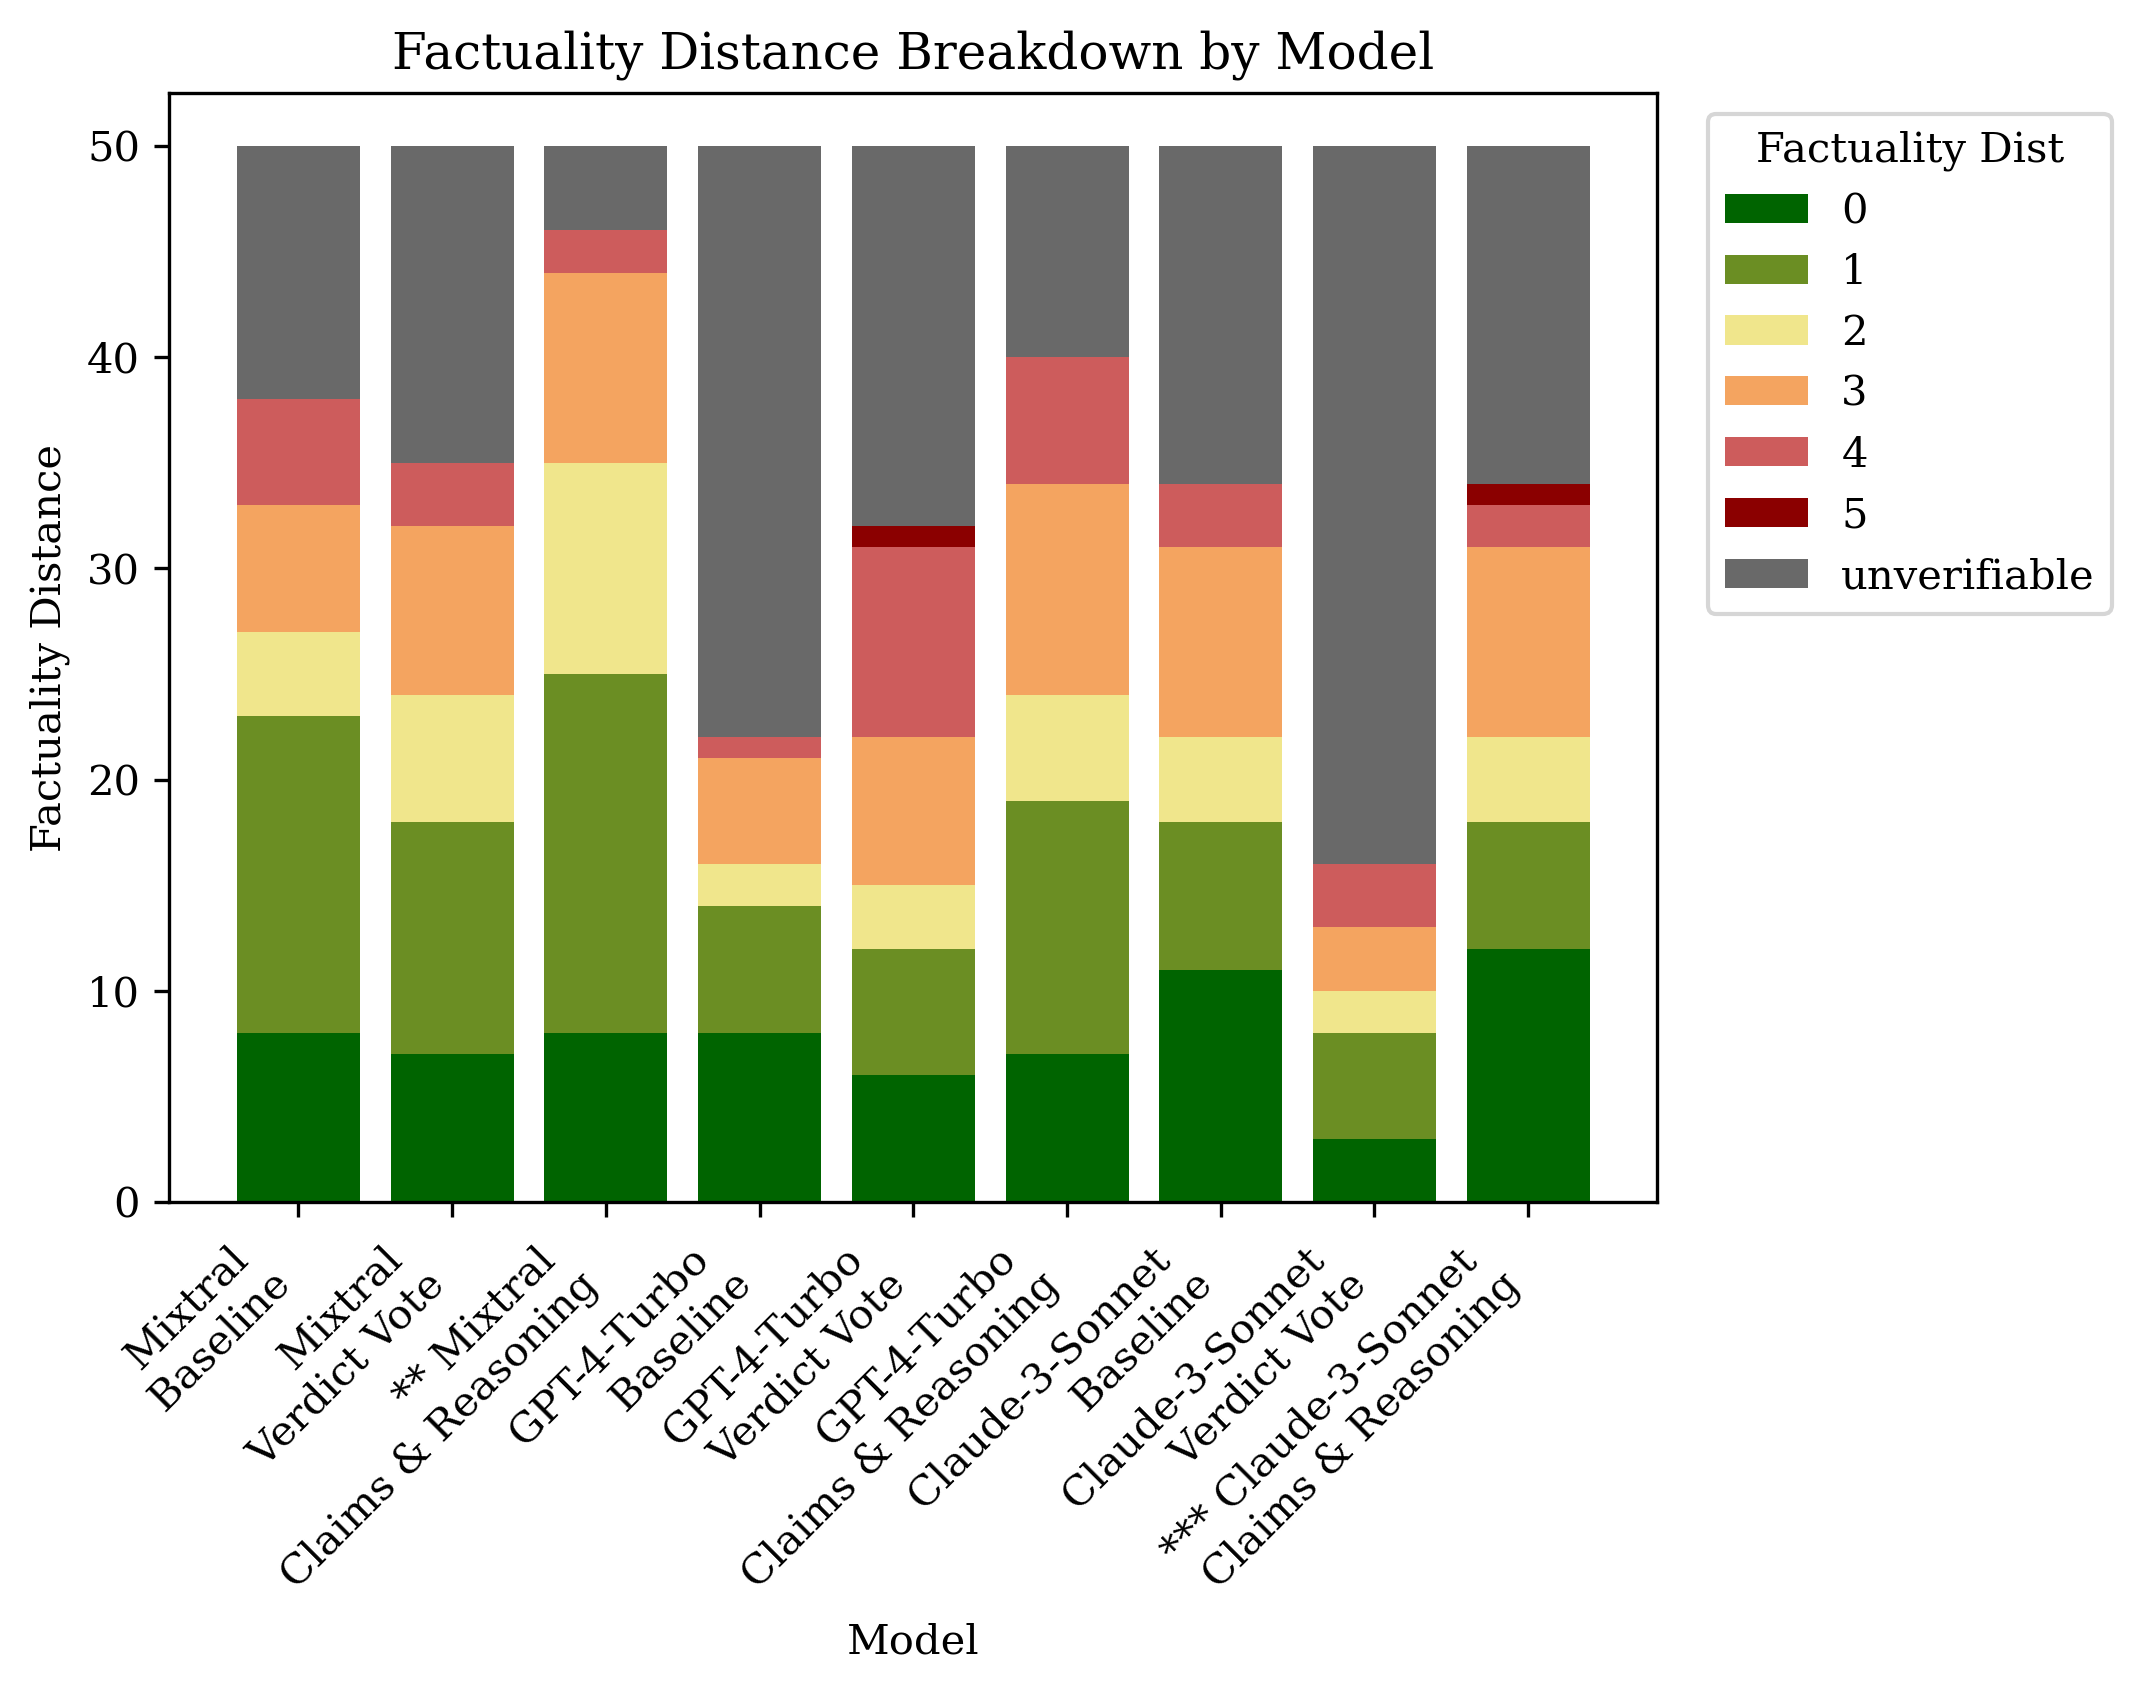

In [446]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
 
# transposed arrays
counts = list(zip(mixtral_baseline_fact_dist, mixtral_complete_fact_dist, mixtral_reasoning_fact_dist,
                  gpt_baseline_fact_dist, gpt_complete_fact_dist,gpt_reasoning_fact_dist, 
                  claude_baseline_fact_dist, claude_complete_fact_dist, claude_reasoning_fact_dist)) 
# create data
x = ['Mixtral \n Baseline', 'Mixtral \n Verdict Vote', '** Mixtral \n Claims & Reasoning', 
     'GPT-4-Turbo \n Baseline', 'GPT-4-Turbo \n Verdict Vote', 'GPT-4-Turbo \n Claims & Reasoning', 
     'Claude-3-Sonnet \n Baseline', 'Claude-3-Sonnet \n Verdict Vote', '*** Claude-3-Sonnet \n Claims & Reasoning']
y0 = np.array(counts[1])
y1 = np.array(counts[2])
y2 = np.array(counts[3])
y3 = np.array(counts[4])
y4 = np.array(counts[5])
y5 = np.array(counts[6])
y_unverifiable = np.array(counts[0])
 
# plot bars in stack manner
plt.bar(x, y0, color='darkgreen')
plt.bar(x, y1, bottom=y0, color='olivedrab')
plt.bar(x, y2, bottom=y0+y1, color='khaki')
plt.bar(x, y3, bottom=y0+y1+y2, color = 'sandybrown')
plt.bar(x, y4, bottom=y0+y1+y2+y3, color = 'indianred')
plt.bar(x, y5, bottom=y0+y1+y2+y3+y4, color = 'darkred')
plt.bar(x, y_unverifiable, bottom=y0+y1+y2+y3+y4+y5, color = 'dimgrey')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Model")
plt.ylabel("Factuality Distance")
plt.title("Factuality Distance Breakdown by Model")
plt.legend(['0','1','2','3','4','5','unverifiable'], bbox_to_anchor=(1.02, 1), title = 'Factuality Dist')
plt.show()

In [33]:
claude_loose_cm, claude_loose_precision, claude_loose_recall, claude_loose_f1 = generate_metrics(pilot_verdict, claude_fs_loose)

Weighted Precision: 0.43
Weighted Recall: 0.22
Weighted F1 Score: 0.24


# BERT Score

In [290]:
# !pip install bert_score

In [291]:
import bert_score
# hide the loading messages
import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)
from bert_score import score

In [177]:
from bs4 import BeautifulSoup
import re
import requests

def scrape_politifact(url):
    """Scrapes text and metadata from a given website URL."""
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            article_element = soup.find('article', class_='m-textblock')
            if article_element:
                section_element = article_element.find('section', class_='o-pick')
                if section_element:
                    section_element.decompose()
                article_text = article_element.get_text()
                article_text = article_text.replace(u'\xa0', u' ')
                text = re.sub(r'\s+', ' ', article_text).strip()
                return text
    except Exception as e:
        print(f"Error during website scraping: {e}")
        return None

def scrape_snopes(url):
    """Scrapes text and metadata from a given website URL."""
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            article_element = soup.find('article', {'id': 'article-content'})
            if article_element:
                section_element = article_element.find('section', class_='o-pick')
                if section_element:
                    section_element.decompose()
                article_text = article_element.get_text()
                article_text = article_text.replace(u'\xa0', u' ')
                text = re.sub(r'\s+', ' ', article_text).strip()
                return text
    except Exception as e:
        print(f"Error during website scraping: {e}")
        return None

In [241]:
pilot[18:19]['factcheck_analysis_link']

18    https://www.washingtonpost.com/politics/2024/0...
Name: factcheck_analysis_link, dtype: object

In [188]:
from tqdm.auto import tqdm
refs = []
for idx, row in tqdm(pilot.iterrows(), total = len(pilot)):
    factchecker = row['factchecker'].lower()
    url = row['factcheck_analysis_link']
    if factchecker == 'politifact':
        refs.append(scrape_politifact(url))
    elif factchecker == 'snopes':
        refs.append(scrape_snopes(url))
    else:
        refs.append("PLACEHOLDER")   

  0%|          | 0/50 [00:00<?, ?it/s]

In [430]:
cands_gpt_reasoning = gpt_reasoning_df['reasonings'].to_list()
P_gpt_reasoning, R_gpt_reasoning, F1_gpt_reasoning = score(cands_gpt_reasoning, refs, lang='en', verbose=True)
p_bert_gpt_reasoning = P_gpt_reasoning.tolist()
r_bert_gpt_reasoning = R_gpt_reasoning.tolist()
f1_bert_gpt_reasoning = F1_gpt_reasoning.tolist()
print(np.mean(p_bert_gpt_reasoning), np.mean(r_bert_gpt_reasoning), np.mean(f1_bert_gpt_reasoning))

cands_gpt_base = gpt_baseline_df['reasonings'].to_list()
P_gpt_base, R_gpt_base, F1_gpt_base = score(cands_gpt_base, refs, lang='en', verbose=True)
p_bert_gpt_base = P_gpt_base.tolist()
r_bert_gpt_base = R_gpt_base.tolist()
f1_bert_gpt_base = F1_gpt_base.tolist()
print(np.mean(p_bert_gpt_base), np.mean(r_bert_gpt_base), np.mean(f1_bert_gpt_base))

calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 151.26 seconds, 0.33 sentences/sec
0.8497851181030274 0.8077788853645325 0.8281792819499969
calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 150.59 seconds, 0.33 sentences/sec
0.8495868253707886 0.8068014776706696 0.8275840151309967


In [431]:
cands_claude_reasoning = claude_reasoning_df['reasonings'].to_list()
P_claude_reasoning, R_claude_reasoning, F1_claude_reasoning = score(cands_claude_reasoning, refs, lang='en', verbose=True)
p_bert_claude_reasoning = P_claude_reasoning.tolist()
r_bert_claude_reasoning = R_claude_reasoning.tolist()
f1_bert_claude_reasoning = F1_claude_reasoning.tolist()
print(np.mean(p_bert_claude_reasoning), np.mean(r_bert_claude_reasoning), np.mean(f1_bert_claude_reasoning))

cands_claude_base = claude_baseline_df['reasonings'].to_list()
P_claude_base, R_claude_base, F1_claude_base = score(cands_claude_base, refs, lang='en', verbose=True)
p_bert_claude_base = P_claude_base.tolist()
r_bert_claude_base = R_claude_base.tolist()
f1_bert_claude_base = F1_claude_base.tolist()
print(np.mean(p_bert_claude_base), np.mean(r_bert_claude_base), np.mean(f1_bert_claude_base))

calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 105.13 seconds, 0.48 sentences/sec
0.8481460511684418 0.8117743897438049 0.8294965267181397
calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 121.19 seconds, 0.41 sentences/sec
0.841874440908432 0.8152441346645355 0.8283075308799743


In [432]:
cands_mixtral_reasoning = mixtral_df['reasonings'].to_list()
P_mixtral_reasoning, R_mixtral_reasoning, F1_mixtral_reasoning = score(cands_mixtral_reasoning, refs, lang='en', verbose=True)
p_bert_mixtral_reasoning = P_mixtral_reasoning.tolist()
r_bert_mixtral_reasoning = R_mixtral_reasoning.tolist()
f1_bert_mixtral_reasoning = F1_mixtral_reasoning.tolist()
print(np.mean(p_bert_mixtral_reasoning), np.mean(r_bert_mixtral_reasoning), np.mean(f1_bert_mixtral_reasoning))

cands_mixtral_base = [x[1] for x in mixtral_base_list]
P_mixtral_base, R_mixtral_base, F1_mixtral_base = score(cands_mixtral_base, refs, lang='en', verbose=True)
p_bert_mixtral_base = P_mixtral_base.tolist()
r_bert_mixtral_base = R_mixtral_base.tolist()
f1_bert_mixtral_base = F1_mixtral_base.tolist()
print(np.mean(p_bert_mixtral_base), np.mean(r_bert_mixtral_base), np.mean(f1_bert_mixtral_base))

calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 123.86 seconds, 0.40 sentences/sec
0.8144269275665283 0.7884454309940339 0.8011428153514862
calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 123.05 seconds, 0.41 sentences/sec
0.8439566123485566 0.8054204380512238 0.824069800376892


In [357]:
cands_gpt_all = gpt_complete_df['reasonings'].to_list()
P_gpt_all, R_gpt_all, F1_gpt_all = score(cands_gpt_all, refs, lang='en', verbose=True)
p_bert_gpt_all = P_gpt_all.tolist()
r_bert_gpt_all = R_gpt_all.tolist()
f1_bert_gpt_all = F1_gpt_all.tolist()
print(np.mean(p_bert_gpt_all), np.mean(r_bert_gpt_all), np.mean(f1_bert_gpt_all))

calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 142.73 seconds, 0.35 sentences/sec
0.8475891363620758 0.8115316843986511 0.8290035510063172


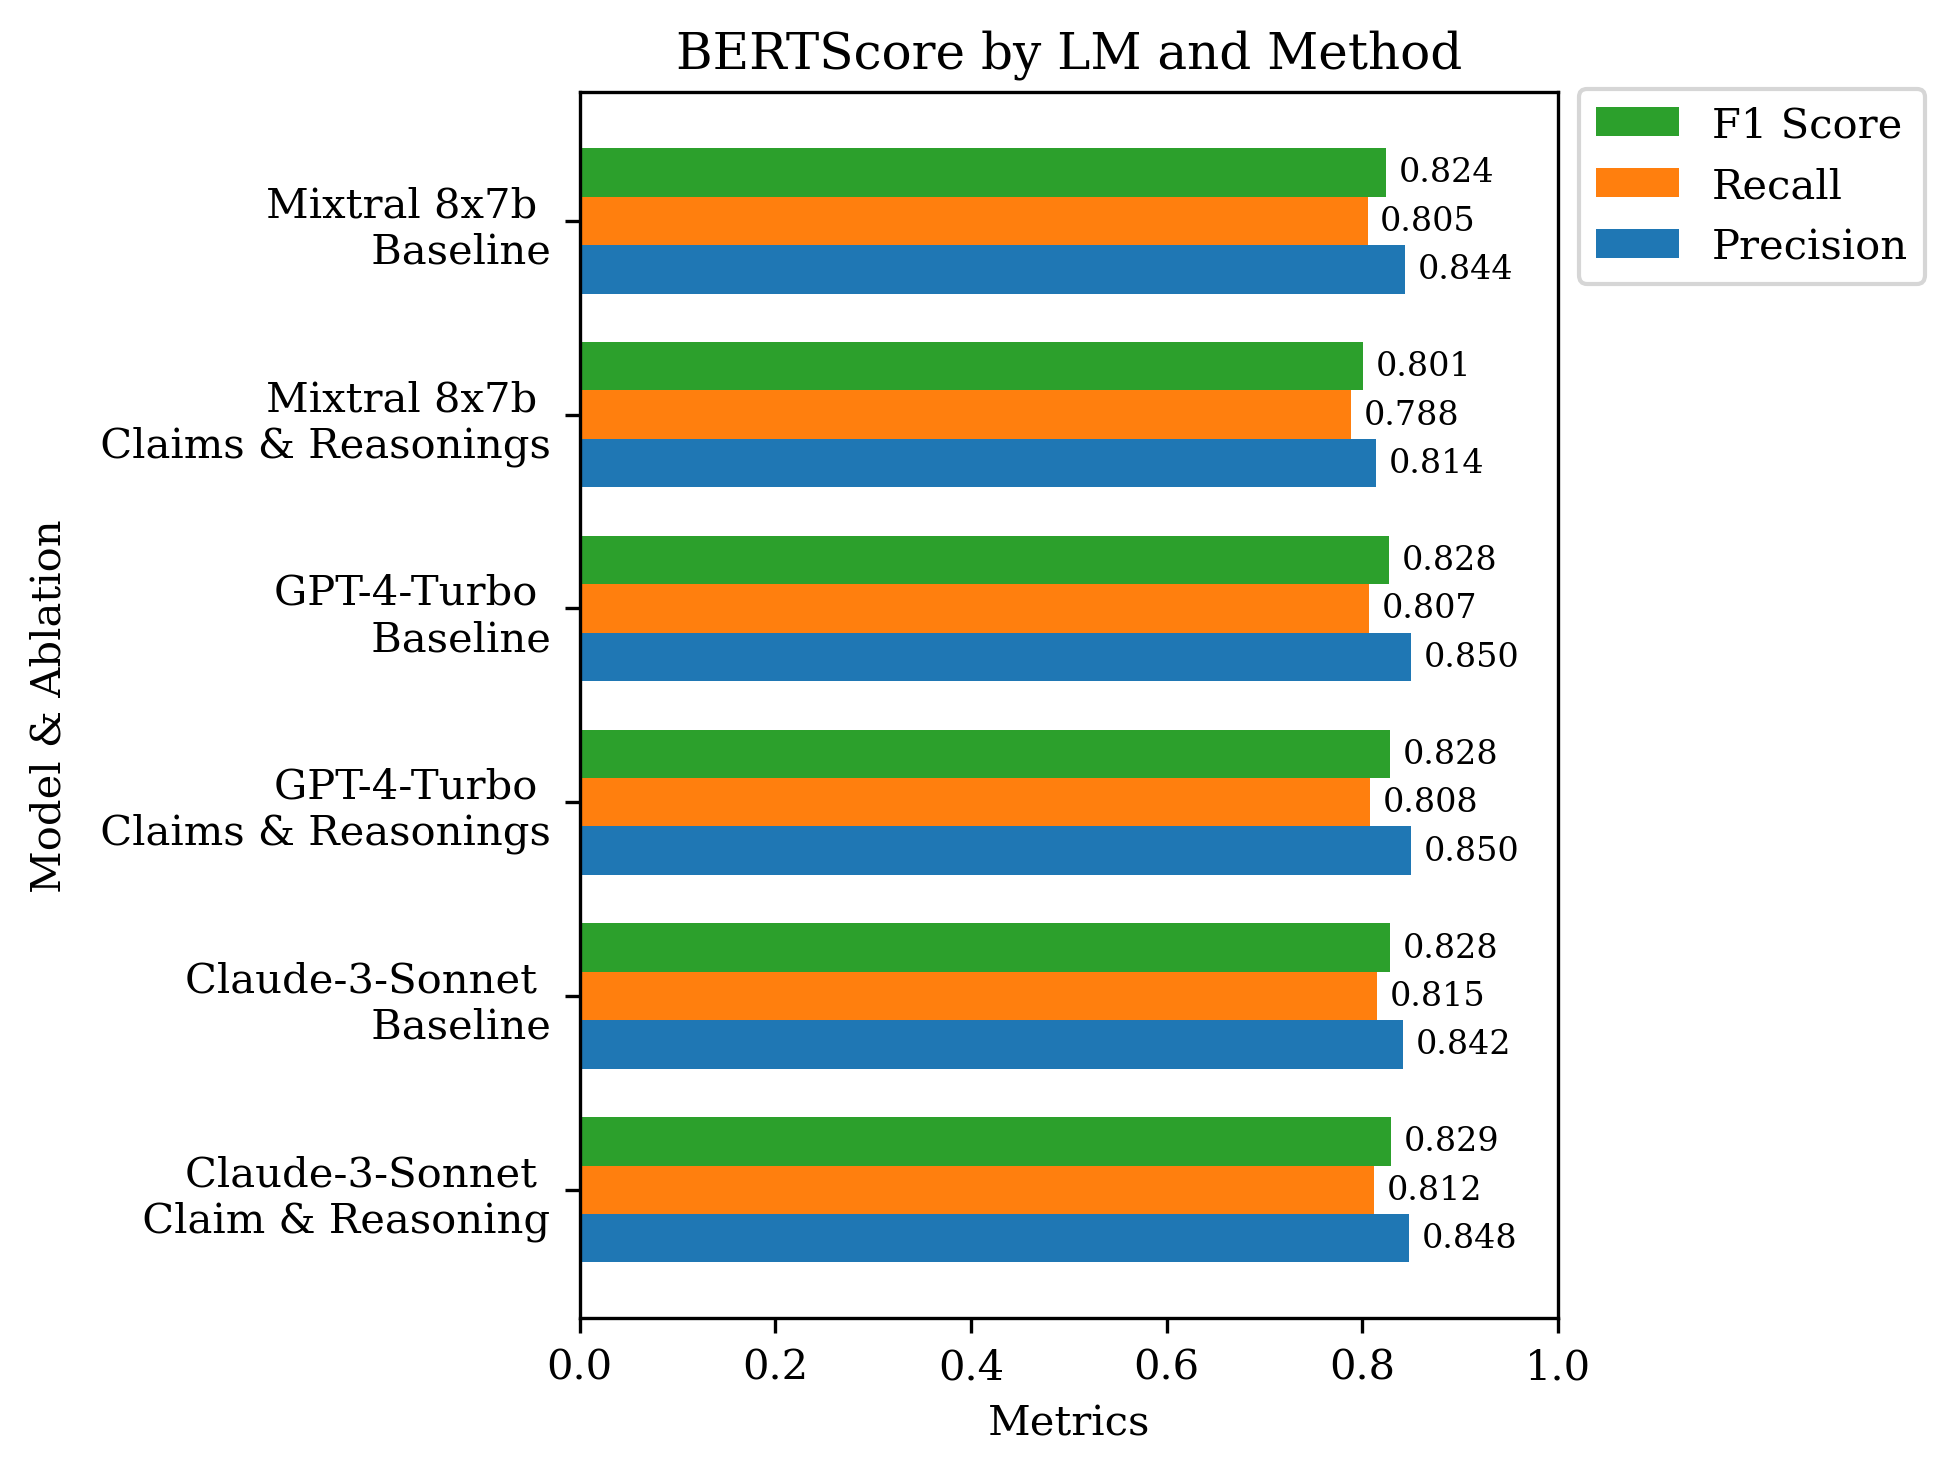

In [435]:
# data from https://allisonhorst.github.io/palmerpenguins/
plt.rcParams["font.family"] = "serif"
labels = ['Claude-3-Sonnet \n Claim & Reasoning', 'Claude-3-Sonnet \n Baseline',
          'GPT-4-Turbo \n Claims & Reasonings', 'GPT-4-Turbo \n Baseline',
          'Mixtral 8x7b \n Claims & Reasonings', 'Mixtral 8x7b \n Baseline']
bert_score = {
    'Precision': (np.mean(p_bert_claude_reasoning), np.mean(p_bert_claude_base), 
               np.mean(p_bert_gpt_reasoning), np.mean(p_bert_gpt_base),
               np.mean(p_bert_mixtral_reasoning), np.mean(p_bert_mixtral_base)),
    'Recall': (np.mean(r_bert_claude_reasoning), np.mean(r_bert_claude_base), 
               np.mean(r_bert_gpt_reasoning), np.mean(r_bert_gpt_base),
               np.mean(r_bert_mixtral_reasoning), np.mean(r_bert_mixtral_base)),
    'F1 Score': (np.mean(f1_bert_claude_reasoning), np.mean(f1_bert_claude_base), 
                 np.mean(f1_bert_gpt_reasoning), np.mean(f1_bert_gpt_base),
                 np.mean(f1_bert_mixtral_reasoning), np.mean(f1_bert_mixtral_base)),
}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in bert_score.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.3f', fontsize = 8)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model & Ablation')
ax.set_xlabel('Metrics')
ax.set_title('BERTScore by LM and Method')
ax.set_yticks(x + width, labels, ha = 'right')
ax.set_xlim(0, 1)
# ax.set_ylim(0, 250)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1,1.02))

In [179]:
temp = pd.read_csv('/Users/sunnyfang/Library/CloudStorage/GoogleDrive-yf2610@barnard.edu/My Drive/courses/AY 23-24/24 SP/COMS-W3997 LLM Foundations & Ethics/LLM Project/[FINAL] Pilot - Pilot Claims.csv')
temp = temp[:50]
temp.to_csv('/Users/sunnyfang/Library/CloudStorage/GoogleDrive-yf2610@barnard.edu/My Drive/courses/AY 23-24/24 SP/COMS-W3997 LLM Foundations & Ethics/LLM Project/LLM-FactChecker/data/cleaned_pilot.csv')